# Generating the Input Joint Distribtution 

The first step to apply an information bottleneck algorithm is to define a proper input distribution $p(x,y)$ which describes the relation between the relevant variable $X$ and the observed random variable $Y$ 

First, we assume an AWGN channel with BPSK transmission.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline

import pyldpc as ldpc
import os
from tqdm.notebook import tqdm
import itertools
from scipy.stats import norm
import scipy

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from utils_f import load_code
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
sigma_n2 = 0.3 # Noise variance
amplitudes = np.array([-1,+1]) # BPSK amplitudes are +1 and -1

p_x = np.array([0.5,0.5]) # uniformly distributed transmit symbols

card_Y = 2000 # choose a fine discretization of the cont. variable Y
card_T = 16   # cardinality of the compression variable
y = np.linspace(norm.ppf(1e-12, loc=amplitudes.min(), scale=np.sqrt(sigma_n2)),
                norm.ppf(1-1e-12, loc=amplitudes.max(), scale=np.sqrt(sigma_n2)), card_Y) # define the eventspace
delta_y = np.abs(y[1] - y[0])

p_y_given_x = np.zeros((y.shape[0],2))
for x_idx, x in enumerate(amplitudes):
    p_y_given_x[:,x_idx] = norm.pdf(y, loc=x, scale=np.sqrt(sigma_n2))*delta_y
    
p_y_and_x = p_y_given_x * p_x
p_y_and_x /= p_y_and_x.sum()

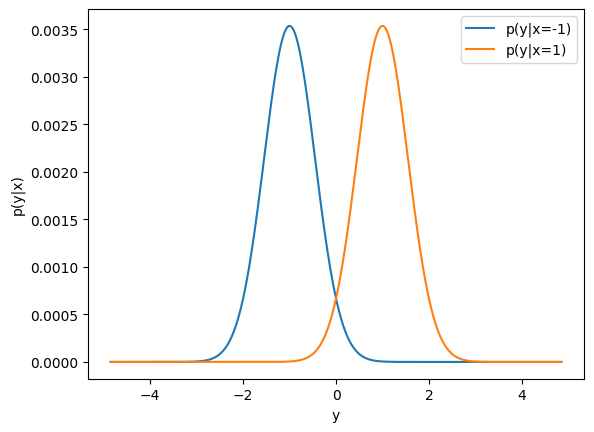

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
for x_idx, x in enumerate(amplitudes):
    plt.plot(y,p_y_given_x[:,x_idx],label="p(y|x="+str(x)+")")
plt.ylabel("p(y|x)")
plt.xlabel("y")
plt.legend()
plt.show()

# What to do

1) Optimize & rebuild code 
1) Try different SNR's
2) Calc mutual info, plot for different algorhytms

## Information theory tools

In [4]:
def log2_stable(value):
    """ Return the base 2 logarithm. Numerically stable is ensured by catching special cases, namely 0. """
    if np.any(value <= 0):
        if np.isscalar(value):
            return -1e6
        result = np.empty_like(value)
        result[value > 0] = np.log2(value[value > 0])
        result[value <= 0] = -1e6
        return result
    return np.log2(value)


def mutual_information(input_pdf):
    """ Return the Mutual Information for a given base an joint distribution sum over joint matrix over the rows
    to determine p_x.
    Args:
    input_pdf = a 2D array containing the joint probabilities. For p(x,y) x is fixed for a particular column and y is
                fixed in one row.
    """
    p_x = input_pdf.sum(0, keepdims=True)
    # sum over joint matrix over the columns to determine p_y
    p_y = input_pdf.sum(1, keepdims=True)
    MI = (input_pdf * log2_stable(input_pdf / (p_y.dot(p_x) + 1e-31))).sum()
    return MI


def kl_divergence(pdf1, pdf2):
    """ Return the Kullback-Leibler Divergence for two input PDFs. For use in IB algorithm.
    Note:
        The KL-divergence is not a real metric, the order of the input matters.
    Args:
    pdf1 =  a 2D array containing the joint probabilities. For p(x|y) x is fixed for a particular column and y is
            fixed in one row.
    pdf2 =  a 2D array containing the joint probabilities. For p(x|t) t is fixed for a particular column and x is
            fixed in one row.
    Note:
        It is also possible to input only an 1D array, which will be extended automatically using broadcasting.
        If the first pdf1 is a 1D arrays it is extended with pdf1[np.newaxis,:] to turn it in a row vector.
    """
    if pdf1.ndim == 1:
        pdf1 = pdf1[np.newaxis, :]
    KL_vec = (pdf1 * log2_stable(pdf1 / (pdf2 + 1e-31))).sum(1)
    return KL_vec




def js_divergence(pdf1, pdf2, pi1, pi2):
    """Return the Jenson-Shannen Divergence for two input PDFs and given pi1 and pi2.
    Note:
        The JS is the symmetrized and smoothed version of the KL-divergence.
    Args:
    pdf1 = a 2D array containing joint probabilities.
    pdf2 = a 2D array containing joint probabilities.
    pi1 = weighting factor
    pi2 = weighting factor
    """
    # catch special case that pi1 is a vector appears for sIB algorihtms
    if False in (np.isscalar(pi1), np.isscalar(pi2)):
        p_tilde_mat = pi1[:, np.newaxis] * pdf1 + pi2[:, np.newaxis] * pdf2
    else:
        p_tilde_mat = pi1 * pdf1 + pi2 * pdf2
    JS_vec = pi1 * kl_divergence(pdf1, p_tilde_mat) + pi2 * kl_divergence(pdf2, p_tilde_mat)
    return JS_vec


## Running Information Bottleneck Algorithms

In this section, we will use three exemplary information bottleneck algorithm to show the syntax of the respective algorithms and how to access the lookup table $p(t|y)$ and the cluster meaning $p(x|t)$.

In [5]:
import sys

class GenericIB:
    """Common base class for all Information Bottleneck classes
    Args:
    input parameter
        p_x_y                   input joint pdf, where x is the number of columns and y the number of rows
    IB related parameters
        cardinality_T
        beta
        eps
        nror
    mutual information
        MI_XT                   mutual information of output I(X;T)
        MI_XY                   mutual information of input I(X;Y)
    output PDF_s
        p_t_given_y
        p_x_given_t
        p_t
    """

    def __init__(self, p_x_y_, card_T_, beta_, eps_ , nror_):
        # initialize parameters
        self.p_x_y = p_x_y_
        self.cardinality_T = card_T_
        self.beta = beta_
        self.eps = eps_
        self.nror = nror_

        # initialize unused parameters
        self.MI_XT = 1
        self.MI_XY = 1
        self.p_t_given_y = np.zeros((self.p_x_y.shape[0], self.cardinality_T))
        self.p_x_given_t = np.zeros((self.cardinality_T, self.p_x_y.shape[1]))
        self.p_t = np.zeros((1,self.cardinality_T))
        self.name = 'GenericClass'

        if card_T_ >= self.p_x_y.shape[0]:
            raise RuntimeError('The number of desired clusters is larger/equal than the input cardinality |T|>=|Y| !!')

    def calc_merger_cost(self):
        """Return the merger cost for putting one event in a cluster.
        Args:
            p_t: is a 1 x card_T array
            p_x_given_t: is a card_X x card_T array
        """
        # p_t_bar is the sum of the last element, corresponding to cardinality T, and the vector except of the last
        # element
        p_t_bar = self.p_t[ -1] + self.p_t[:- 1]

        pi1 = self.p_t[-1] / p_t_bar
        pi2 = self.p_t[:-1] / p_t_bar

        cost_vec = p_t_bar * (js_divergence(self.p_x_given_t[-1, :], self.p_x_given_t[:-1, :], pi1, pi2) -
                    (pi1 * np.log2(pi1)+pi2 * np.log2(pi2)) / self.beta)

        return cost_vec

    def run_IB_algo(self):
        """only template that will be used by the specific implementations later."""
        pass

    def return_results(self):
        """Return all parameters generate by the Information Bottleneck as dictionary
        Return:
            :return p_t_given_y:
            :return p_x_given_t:
            :return p_t:
            :return MI_XT:
            :return MI_XY:
        Note: These are the strings of the dictionary elements.
        """
        return {'p_t_given_y': self.p_t_given_y,
                'p_x_given_t': self.p_x_given_t,
                'p_t': self.p_t,
                'MI_XT': self.MI_XT,
                'MI_XY': self.MI_XY }

    def display_MIs(self,short=False):
        """Return the Mutual information for the input pdf and after applying the IB as well as the ratio of both in a
        graphical way.
        Args:
            None
        Return:
            None
        """
        if short:
            print('MI_XT_s= ', str(self.MI_XT))
        else:
            print('----- Mutual Information Comp --- ')
            print('----- ', self.name, ' ------ ')
            print('MI_XT_s= ', str(self.MI_XT))
            print('MI_XY_s= ', str(self.MI_XY))
            print('ratio= ', str(self.MI_XT / self.MI_XY))

    def printProgress(self, iteration, total, prefix='', suffix='', decimals=2, barLength=70):
        """
        Call in a loop to create terminal progress bar
        Args:
            iteration   - Required  : current iteration (Int)
            total       - Required  : total iterations (Int)
            prefix      - Optional  : prefix string (Str)
            suffix      - Optional  : suffix string (Str)
            decimals    - Optional  : number of decimals in percent complete (Int)
            barLength   - Optional  : character length of bar (Int)
        """
        filledLength = int(round(barLength * (iteration + 1) / float(total)))
        percents = round(100.00 * ((iteration + 1) / float(total)), decimals)
        bar = '#' * filledLength + '-' * (barLength - filledLength)
        sys.stdout.write('\r')
        sys.stdout.write('%s [%s] %s%s %s / %s   %s \r' % (prefix, bar, percents, '%', iteration + 1, total, suffix)),
        sys.stdout.flush()
        if iteration+1 == total:
            print("\n")

    def get_results(self):
        return self.p_t_given_y, self.p_x_given_t, self.p_t

    def get_mutual_inf(self):
        return self.MI_XT, self.MI_XY

### Sequential Symmetric Information Bottleneck Algorithm [LB18]

In [6]:
class symmetric_sIB(GenericIB):
    """This class realizes the calculation of the modified sequential Information Bottleneck algorithm that outputs
        symmetric clusters.
      Description:
        The class implements the algorithm for the creation of the Trellis
        message mappings from the paper. It is an extended version of the
        modified sequential IB algorithm that additionally enforces symmetry of
        the clusters.
      Args:
      input parameter
          p_x_y                     input joint pdf, where x is the number of columns and y the number of rows
      IB related parameters
          cardinality_T
          beta                      is set to Inf for the sIB
          eps                       not used in this algorithm set to []
          nror                      number of runs
      Return:
      mutual information
          MI_XT                     mutual information of output I(X;T)
          MI_XY                     mutual information of input I(X;Y)
      output PDF_s
          p_t_given_y
          p_x_given_t
          p_t
      Note: The values can be accessed using the appropriate return functions of the class
        self.return_results         return all values
        self.display_MI             return the MIs graphically as well as percentage of maintained mutual information
      """

    def __init__(self, p_x_y_, card_T_, nror_):
        GenericIB.__init__(self, p_x_y_, card_T_, np.inf, [], nror_)
        self.name = 'symmetric sIB'

    def run_IB_algo(self):
        if self.cardinality_T == 2:
            self.cardinality_Y = self.p_x_y.shape[0]
            self.p_t_given_y = np.zeros((self.cardinality_Y, 2))
            self.p_t_given_y[0:int(self.cardinality_Y / 2) , 1] = 1
            self.p_t_given_y[int(self.cardinality_Y / 2):, 0] = 1
            self.p_y=self.p_x_y.sum(axis=1)

            # calculate p(t)  new
            self.p_t = (self.p_t_given_y[:, :self.cardinality_T] * self.p_y[:, np.newaxis]).sum(0)

            # calculate p(x | t) new
            self.p_x_given_t = 1 / (self.p_t[:self.cardinality_T, np.newaxis]) * np.dot(self.p_t_given_y[:, :self.cardinality_T].T,
                                                                            self.p_x_y)
        else:
            self.symmetric_sIB_algo()

    def calc_merger_cost(self, border_between_clusters, cur_card_T_):
        """Return the merger cost for putting one event in a cluster. Since this a modified version of the sIB only two
            clusters have to be tested. Which constrains the calculation to two comparisons.
            Args:
                :param border_between_clusters: denotes the current border between two adjacent cluster, optimized in this step
                :param cur_card_T_: The current cardinality T, meaning the cluster size, which is increased during the
                                    algorithm due to temporary clusters
            Return
                :return cost_vec:
            """

        # p_t_bar is the sum of the last element, corresponding to cardinality T, and the vector except of the last
        # element
        bbc = border_between_clusters
        cur_card_T = cur_card_T_-2
        p_t_bar = self.p_t[cur_card_T] + self.p_t[[bbc, bbc+1]]

        pi1 = self.p_t[cur_card_T] / p_t_bar
        pi2 = self.p_t[[bbc, bbc+1]] / p_t_bar

        cost_vec = p_t_bar * (js_divergence(self.p_x_given_t[cur_card_T, :], self.p_x_given_t[[bbc, bbc+1], :], pi1, pi2)
                              -(pi1 * np.log2(pi1) + pi2 * np.log2(pi2)) / self.beta)

        return cost_vec

    def symmetric_sIB_algo(self):
        # set static values
        p_x = self.p_x_y.sum(0)
        p_y = self.p_x_y.sum(1)

        cardinality_X=p_x.shape[0]
        cardinality_Y=p_y.shape[0]

        cur_card_T = self.cardinality_T

        # Initialization

        # preallocate arrays
        ib_fct = np.zeros(self.nror)
        I_YT = np.zeros(self.nror)
        I_TX = np.zeros(self.nror)
        p_t_given_y_mats = np.zeros((cardinality_Y, self.cardinality_T , self.nror))
        p_t_mats = np.zeros((1, self.cardinality_T, self.nror))
        p_x_given_t_mats = np.zeros((self.cardinality_T, cardinality_X, self.nror))
        all_needed = 0
        # run for-loop for each number of run
        for run in range(0, self.nror):
            self.printProgress(run, self.nror,prefix='Run:')

            self.p_t_given_y = np.zeros((cardinality_Y, self.cardinality_T + 2))

            # Initialization of p_t_given_y
            # Use dirichlet distribution to sample a valid density
            # the ones vector indicate that The expected value for each cluster is 1/(cardinaltiy_T)
            # Multiplying with constant changes variance. 1 means very high variance creating asymmetric clusters.
            # In the end +1 is needed to ensure that
            alpha = np.ones(int(self.cardinality_T / 2)) * 1
            border_vec = np.ones(alpha.shape[0]) * cardinality_Y / 2
            while border_vec[:-1].cumsum().max() >= cardinality_Y / 2:
                border_vec = np.floor(np.random.dirichlet(alpha, 1).transpose() * (cardinality_Y / 2))
                border_vec[border_vec == 0] = 1

            border_vec = np.hstack([border_vec[:-1].cumsum(), cardinality_Y / 2]).astype(int)

            a = 0
            for t in range(0, int(self.cardinality_T / 2)):
                self.p_t_given_y[a:border_vec[t], t] = 1
                self.p_t_given_y[cardinality_Y - border_vec[t] :cardinality_Y - a, self.cardinality_T - t -1] = 1
                a = border_vec[t]


            # Processing
            init_mat = self.p_t_given_y
            end_mat = np.zeros((cardinality_Y, self.cardinality_T + 2))

            # repeat until stable solution found
            while not np.array_equal(init_mat, end_mat):
                self.p_t = (self.p_t_given_y * p_y[:, np.newaxis]).sum(0)

                all_needed +=1

                last_cluster_vec = np.hstack([np.zeros(self.cardinality_T), 1, 0])
                partner_last_cluster_vec = np.hstack([np.zeros(self.cardinality_T), 0, 1])

                init_mat = np.copy(self.p_t_given_y)

                for border_between_clusters in range(0,int(self.cardinality_T/2) - 1):
                    done_left_to_right = False
                    done_right_to_left = False

                    while not done_left_to_right:
                        done_left_to_right = True
                        all_needed += 1
                        # find last element in the cluster
                        # this is a trick here because argmax returns first hit so we flip the array first.
                        last_elem = self.p_t_given_y.shape[0] - np.argmax(self.p_t_given_y[::-1, border_between_clusters] > 0) - 1

                        old_cluster = border_between_clusters

                        if np.sum(self.p_t_given_y[:, old_cluster]) > 1:
                            self.p_t_given_y[last_elem, :] = last_cluster_vec
                            self.p_t_given_y[-(last_elem+1), :] = partner_last_cluster_vec

                            cur_card_T += 2

                            # calculate p(t)  new
                            self.p_t = (self.p_t_given_y[:, :cur_card_T] * p_y[:, np.newaxis]).sum(0)

                            # calculate p(x | t) new
                            self.p_x_given_t = 1/(self.p_t[:cur_card_T, np.newaxis]) * np.dot(self.p_t_given_y[:, :cur_card_T].T, self.p_x_y)

                            merger_costs_vec = self.calc_merger_cost(border_between_clusters, cur_card_T)

                            ind_min = np.argmin(merger_costs_vec)

                            if ind_min == 0:
                                self.p_t_given_y[last_elem, border_between_clusters] = 1
                                self.p_t_given_y[cardinality_Y-last_elem-1, cur_card_T-2-border_between_clusters-1] = 1

                            else:
                                self.p_t_given_y[last_elem, border_between_clusters+1] = 1
                                self.p_t_given_y[- (last_elem+1), cur_card_T - 2 - border_between_clusters-2] = 1
                                done_left_to_right = False

                            self.p_t_given_y[-(last_elem+1), -1] = 0
                            self.p_t_given_y[last_elem, - 2] = 0

                            cur_card_T -= 2

                    # check other direction
                    while not done_right_to_left:
                        done_right_to_left = True
                        all_needed += 1
                        # find first element in the cluster
                        first_elem = np.argmax(self.p_t_given_y[:, border_between_clusters + 1] > 0)

                        old_cluster = border_between_clusters + 1
                        if np.sum(self.p_t_given_y[:, old_cluster]) > 1:
                            self.p_t_given_y[first_elem, :] = last_cluster_vec
                            self.p_t_given_y[cardinality_Y - first_elem - 1, :] = partner_last_cluster_vec

                            cur_card_T += 2

                            # calculate p(t)  new
                            self.p_t = (self.p_t_given_y[:, :cur_card_T] * p_y[:, np.newaxis]).sum(0)

                            # calculate p(x | t) new
                            self.p_x_given_t = 1 / (self.p_t[:cur_card_T, np.newaxis]) * np.dot(self.p_t_given_y[:, :cur_card_T].T, self.p_x_y)

                            merger_costs_vec = self.calc_merger_cost(border_between_clusters, cur_card_T)

                            ind_min = np.argmin(merger_costs_vec)

                            if ind_min == 0:
                                self.p_t_given_y[first_elem, border_between_clusters] = 1
                                self.p_t_given_y[cardinality_Y - first_elem - 1, cur_card_T - 2 - border_between_clusters-1] = 1

                                done_right_to_left = False
                            else:
                                self.p_t_given_y[first_elem, border_between_clusters + 1] = 1
                                self.p_t_given_y[cardinality_Y - first_elem-1, cur_card_T - 2 - border_between_clusters-2] = 1

                            self.p_t_given_y[cardinality_Y - first_elem - 1, cur_card_T - 1] = 0
                            self.p_t_given_y[first_elem, cur_card_T - 2] = 0
                            cur_card_T -= 2

                end_mat = self.p_t_given_y

            # calculate p(t)  new
            self.p_t = (self.p_t_given_y[:, :cur_card_T] * p_y[:, np.newaxis]).sum(0)

            # calculate p(x | t) new
            self.p_x_given_t = 1 / (self.p_t[:cur_card_T, np.newaxis]) * np.dot(self.p_t_given_y[:, :cur_card_T].T, self.p_x_y)

            p_t_given_y_mats[:, :, run] = self.p_t_given_y[:, :self.cardinality_T]
            p_t_mats[:, :, run] = self.p_t
            p_x_given_t_mats[:, :, run] = self.p_x_given_t[:self.cardinality_T, :]

            p_ty = self.p_t_given_y[:, :self.cardinality_T] * p_y[:, np.newaxis]
            p_xt = self.p_x_given_t[:self.cardinality_T, :] * self.p_t[:, np.newaxis]

            I_YT[run] = mutual_information(p_ty)
            I_TX[run] = mutual_information(p_xt)

            ib_fct[run] = I_YT[run] / (-self.beta) + I_TX[run]

        # choose the run maximizing the Information Bottleneck functional
        winner = np.argmax(ib_fct)
        self.p_t_given_y = p_t_given_y_mats[:, :, winner].squeeze()
        self.p_x_given_t = p_x_given_t_mats[:, :, winner].squeeze()
        self.p_t = p_t_mats[:, :, winner].squeeze()
        self.MI_XY = mutual_information(self.p_x_y)
        self.MI_XT = I_TX[winner]

In [7]:
IB_algo = symmetric_sIB(p_x_y_=p_y_and_x,
                        card_T_=card_T,
                        nror_=10)
IB_algo.run_IB_algo()

Run: [######################################################################] 100.0% 10 / 10    



In [8]:
IB_algo.display_MIs()

----- Mutual Information Comp --- 
-----  symmetric sIB  ------ 
MI_XT_s=  0.8713385259477824
MI_XY_s=  0.8724135198414117
ratio=  0.9987677931747038


In [9]:
# LUT p(t|y)
p_t_given_y, p_x_given_t, p_t  = IB_algo.get_results()
LUT = np.argmax(IB_algo.p_t_given_y,axis=1)

Text(0, 0.5, 'L(x|t)')

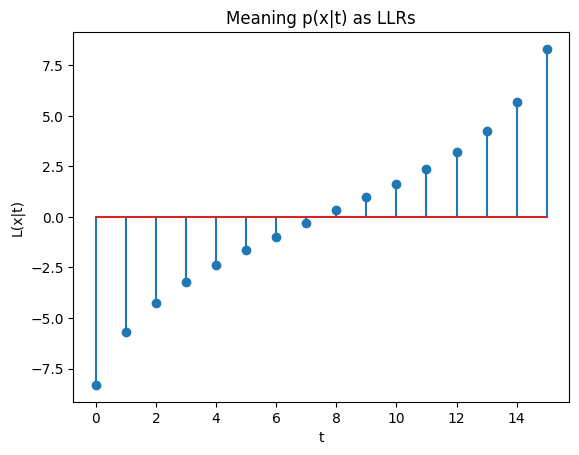

In [10]:
plt.stem(np.arange(card_T),np.log(p_x_given_t[:,1]/p_x_given_t[:,0]))
plt.title("Meaning p(x|t) as LLRs")
plt.xlabel("t")
plt.ylabel("L(x|t)")

### Agglomerative Information Bottleneck Algorithm [Slo02]

In [11]:
class aIB(GenericIB):
    """This class can be used to perform the Agglomerative Information Bottleneck algorithm.
      Args:
      input parameter
          p_x_y                     input joint pdf, where x is the number of columns and y the number of rows
      IB related parameters
          cardinality_T
          beta                      is set to Inf for the sIB
          eps                       not used in this algorithm set to []
          nror                      number of runs
      Return:
      mutual information
          MI_XT                     mutual information of output I(X;T)
          MI_XY                     mutual information of input I(X;Y)
      output PDF_s
          p_t_given_y
          p_x_given_t
          p_t
      Note: The values can be accessed using the appropriate return functions of the class
        self.return_results         return all values
        self.display_MI             return the MIs graphically as well as percentage of maintained mutual information
      """

    def __init__(self, p_x_y_, card_T_):
        GenericIB.__init__(self, p_x_y_, card_T_, np.inf, [], 5)
        self.name = 'agglomerative IB'

        self.cardinality_X=p_x_y_.shape[1]
        self.cardinality_Y=p_x_y_.shape[0]
        self.cost_mat= np.zeros((self.cardinality_Y,self.cardinality_Y))+np.inf

        self.merge_costs = dict()

        self.index_list = np.arange(self.cardinality_Y).tolist()
        self.index_vec = np.arange(self.cardinality_Y)

    def calc_merger_cost_pair(self,ind1,ind2):
        """Return the merger cost for putting one event in a cluster.
        Args:
            p_t: is a 1 x card_T array
            p_x_given_t: is a card_X x card_T array
        """
        # p_t_bar is the sum of the last element, corresponding to cardinality T, and the vector except of the last
        # element

        ind1 = self.index_list.index(ind1)
        ind2 = self.index_list.index(ind2)

        p_t_bar = self.p_t[ind1] + self.p_t[ind2]

        pi1 = self.p_t[ind1] / p_t_bar
        pi2 = self.p_t[ind2] / p_t_bar

        self.cost_mat[ind1,ind2] = p_t_bar * (js_divergence(self.p_x_given_t[ind1, :], self.p_x_given_t[ind2, :], pi1, pi2) -
                              (pi1 * np.log2(pi1) + pi2 * np.log2(pi2)) / self.beta)


        if self.cost_mat[ind1,ind2]<0:
            self.cost_mat[ind1, ind2] = 0

        return self.cost_mat[ind1,ind2]

    def calc_merger_cost_pair_vec(self,ind1,ind2):
        """Return the merger cost for putting one event in a cluster.
        Args:
            p_t: is a 1 x card_T array
            p_x_given_t: is a card_X x card_T array
        """
        # p_t_bar is the sum of the last element, corresponding to cardinality T, and the vector except of the last
        # element

        p_t_bar = self.p_t[ind1] + self.p_t[ind2]

        pi1 = self.p_t[ind1] / p_t_bar
        pi2 = self.p_t[ind2] / p_t_bar

        self.cost_mat[ind1,ind2] = p_t_bar * (js_divergence(self.p_x_given_t[ind1, :], self.p_x_given_t[ind2, :], pi1, pi2) -
                              (pi1 * np.log2(pi1) + pi2 * np.log2(pi2)) / self.beta)

        self.cost_mat[self.cost_mat < 0] = 0

    def calc_all_merge_costs(self):
        """
        This function is called only once, during initialization of Partition
        Subsequent calls operate on a subset of the data
        """

        ind1 = np.kron(np.arange(self.cardinality_Y), np.ones(self.cardinality_Y))
        ind2 = np.tile(np.arange(self.cardinality_Y),self.cardinality_Y)
        valid_combinations = ind1<ind2
        ind1 = ind1[valid_combinations].astype(int)
        ind2 = ind2[valid_combinations].astype(int)

        self.calc_merger_cost_pair_vec(ind1, ind2)


    def find_merge_pair(self):
        """
        Search all cluster pairs for the best pair to merge.
        Use the following criteria:
        1) Find pair(s) for which merge cost is minimized
        2) If multiple candidates from (1), find pair with smallest inter-cluster distance
        """

        min_pair = min(self.merge_costs, key=lambda x: self.merge_costs[x])

        min_val = self.merge_costs[min_pair]

        assert min_val == self.calc_merger_cost_pair(*min_pair)
        ties = [k for k, v in self.merge_costs.items() if v == min_val]

        if len(ties) > 1:
            min_pair = ties[0]
        return min_pair

    def find_merge_pair_vec(self):
        """
        Search all cluster pairs for the best pair to merge.
        Use the following criteria:
        1) Find pair(s) for which merge cost is minimized
        2) If multiple candidates from (1), find pair with smallest inter-cluster distance
        """

        min_pair = np.unravel_index(np.argmin(self.cost_mat), self.cost_mat.shape)

        return min_pair

    def merge(self,i,j):

        target, remove = sorted([i, j])

        target = self.index_list.index(target)
        remove = self.index_list.index(remove)

        del self.index_list[remove]

        # delete column in p(t|y)
        self.p_t_given_y[:,target] = self.p_t_given_y[:,target]+self.p_t_given_y[:,remove]
        self.p_t_given_y = np.delete(self.p_t_given_y, remove, axis=1)

        # delete row in p(x|t)
        # update p(t)

        self.p_t[target] = self.p_t[target] + self.p_t[remove]
        self.p_t = np.delete(self.p_t, remove, axis=0)

        self.p_x_and_t[target,:] = self.p_x_and_t[target,:] + self.p_x_and_t[remove,:]
        self.p_x_and_t = np.delete(self.p_x_and_t, remove, axis=0)

        self.p_x_given_t[target,:] = 1 / self.p_t[target] * (self.p_x_and_t[target,:] )
        self.p_x_given_t = np.delete(self.p_x_given_t, remove, axis=0)

    def merge_vec(self,i,j):

        target, remove = sorted([i, j])

        del self.index_list[remove]

        # delete column in p(t|y)
        self.p_t_given_y[:,target] = self.p_t_given_y[:,target]+self.p_t_given_y[:,remove]
        self.p_t_given_y = np.delete(self.p_t_given_y, remove, axis=1)

        # delete row in p(x|t)
        # update p(t)
        self.p_t[target] = self.p_t[target] + self.p_t[remove]
        self.p_t = np.delete(self.p_t, remove, axis=0)

        self.p_x_and_t[target,:] = self.p_x_and_t[target,:] + self.p_x_and_t[remove,:]
        self.p_x_and_t = np.delete(self.p_x_and_t, remove, axis=0)

        self.p_x_given_t[target,:] = 1 / self.p_t[target] * (self.p_x_and_t[target,:] )
        self.p_x_given_t = np.delete(self.p_x_given_t, remove, axis=0)

    def merge_next(self):
        """
        Iterate the AIB algorithm.
        Find best pair to merge, perform merge, update clusters and merge costs for next iteration
        """
        # Decide which pair of clusters to merge next
        min_pair = self.find_merge_pair_vec()

        # Execute merge
        self.merge_vec(*min_pair)
        """After merge, recompute costs related to the merged clusters
        Two steps:
            1) Update pointers to point to the merged pair (the min of min_pair)
            2) Process this list with clusters.calc_merge_cost
        """

        target, remove = sorted(min_pair)
        # entries are basically the row and column of remove
        self.cost_mat = np.delete(self.cost_mat, remove,axis=0)
        self.cost_mat = np.delete(self.cost_mat, remove,axis=1)

        #entries to update
        # all entries in target row and column that are not inf
        dummy_vec=np.arange(self.cost_mat.shape[0])
        # check column entries, i.e. ind1 is fixed and ind2 is determined by relevant_entries
        relevant_entries = np.logical_not( np.isinf(self.cost_mat[target,:]))
        ind2 = dummy_vec[relevant_entries]
        ind1 = target * np.ones(ind2.shape[0])
        self.calc_merger_cost_pair_vec(ind1.astype(int),ind2.astype(int))

        # check row entries, i.e. ind2 is fixed and ind1 is determined by relevant_entries
        relevant_entries = np.logical_not( np.isinf(self.cost_mat[:,target]))
        ind1 = dummy_vec[relevant_entries]
        ind2 = target * np.ones(ind1.shape[0])
        self.calc_merger_cost_pair_vec(ind1.astype(int), ind2.astype(int))

    def run_IB_algo(self):
        self.aIB_algo()

    def aIB_algo(self):
        """ This function tries to minimize the information bottleneck functional using the Agglomerative IB (Agg-IB) algorithm.
        This algorithm only allows for deterministic cluster mapping, meaning beta is always set to infinity."""

        # set static values
        p_x = self.p_x_y.sum(0)
        p_y = self.p_x_y.sum(1)

        self.I_XY_list = []
        self.I_XT_list = []

        self.p_x = self.p_x_y.sum(0)
        self.p_y = self.p_x_y.sum(1)

        # in the first step T is a perfect copy of y.
        self.p_t = p_y.copy()
        self.p_t_shortened = self.p_t.copy()

        p_x_and_t =  self.p_x_y.copy()
        self.p_x_and_t = self.p_x_y.copy()

        self.p_x_given_t = p_x_and_t / self.p_t[:,np.newaxis]
        self.p_x_given_t_shortened = self.p_x_given_t.copy()

        self.p_t_given_y = np.eye(self.cardinality_Y)


        self.calc_all_merge_costs()

        while self.p_x_given_t.shape[0]>self.cardinality_T:

            self.merge_next()

            p_xt = self.p_x_given_t * self.p_t[:, np.newaxis]

            self.I_XY_list.append(mutual_information(self.p_x_y))
            self.I_XT_list.append(mutual_information(p_xt))

        self.MI_XY = mutual_information(self.p_x_y)
        self.MI_XT = mutual_information(p_xt)

In [12]:
IB_algo = aIB(p_x_y_=p_y_and_x,
              card_T_=card_T)
IB_algo.run_IB_algo()

In [13]:
IB_algo.display_MIs()

----- Mutual Information Comp --- 
-----  agglomerative IB  ------ 
MI_XT_s=  0.8711029730916213
MI_XY_s=  0.8724135198414117
ratio=  0.9984977917925566


In [14]:
# LUT p(t|y)
p_t_given_y, p_x_given_t, p_t  = IB_algo.get_results()
LUT = np.argmax(IB_algo.p_t_given_y,axis=1)

Text(0, 0.5, 'L(x|t)')

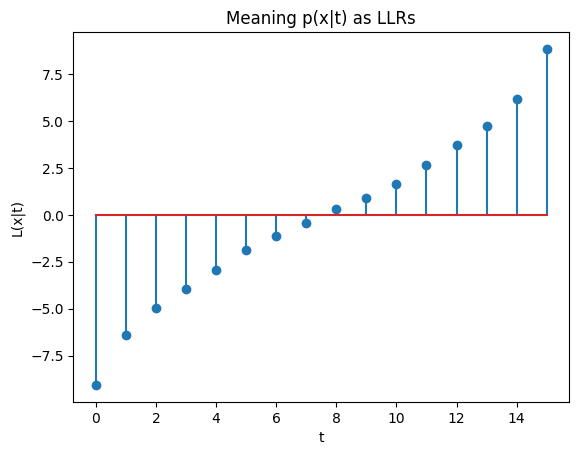

In [15]:
plt.stem(np.arange(card_T),np.log(p_x_given_t[:,1]/p_x_given_t[:,0]))
plt.title("Meaning p(x|t) as LLRs")
plt.xlabel("t")
plt.ylabel("L(x|t)")

### KL-Means Algorithm [K17] 

In [16]:
import pyopencl as cl
import pyopencl.array as cl_array
import pyopencl.tools as cl_tools

class KLmeansIB(GenericIB):
    """This class can be used to perform the KL-Means Information Bottleneck algorithm.
      Args:
      input parameter
          p_x_y                     input joint pdf, where x is the number of columns and y the number of rows
      IB related parameters
          cardinality_T
          beta                      is set to Inf for the sIB
          eps                       not used in this algorithm set to []
          nror                      number of runs
      Return:
      mutual information
          MI_XT                     mutual information of output I(X;T)
          MI_XY                     mutual information of input I(X;Y)
      output PDF_s
          p_t_given_y
          p_x_and_t
          p_t
      Note: The values can be accessed using the appropriate return functions of the class
        self.return_results         return all values
        self.display_MI             return the MIs graphically as well as percentage of maintained mutual information
      """

    def __init__(self, p_x_y_, card_T_,symmetric_init = False ,nror=50):
        GenericIB.__init__(self, p_x_y_, card_T_, np.inf, [], nror)
        self.name = 'KL means IB'

        self.cardinality_X=p_x_y_.shape[1]
        self.cardinality_Y=p_x_y_.shape[0]
        #self.cost_mat= np.zeros((self.cardinality_Y,self.cardinality_Y))+np.inf

        self.symmetric_init = symmetric_init
        self.p_y = self.p_x_y.sum(1)
        self.p_t = np.zeros(self.cardinality_T)

        # calculate p(x|y)
        self.p_x_given_y = self.p_x_y / self.p_y[:, np.newaxis]

        # sort events by gravity
        #self.sort_events_by_cog_idcs()


    def kl_divergence_mat_col(self,pdf1, pdf2):
        KL_div = np.zeros((pdf1.shape[0], pdf2.shape[0]))

        for c in range(pdf2.shape[0]):
            KL_div[:, c] = kl_divergence(self.p_x_given_y, self.p_x_given_t[c,:])

        return KL_div

    def estimate(self):
        p_t_given_y = np.argmin(self.kl_divergence_mat_col(self.p_x_given_y, self.p_x_given_t), axis=1)

        #ensure that no cluster is empty
        for t in range(self.cardinality_T):
            indices = np.where(p_t_given_y == t)[0]
            if indices.size == 0:
                indices = self.last_resort[t]
                p_t_given_y[int(indices)] = int(t)
            else:
                self.last_resort[t] = indices[-1]

        return p_t_given_y

    def init_openCL(self,set_mem_pool_None = False):
        self.context = cl.create_some_context()
        print('###  OPENCL Device #####')
        print(self.context.get_info(cl.context_info.DEVICES))

        path = os.path.split(os.path.abspath(__file__))
        kernelsource = open(os.path.join(path[0], "IB_kernels.cl")).read()
        tpl = Template(kernelsource)
        rendered_tp = tpl.render(cardinality_T=self.cardinality_T)


        #kernelsource = open("information_bottleneck / information_bottleneck_algorithms / IB_kernels.cl").read()

        self.program = cl.Program(self.context, str(rendered_tp)).build()
        self.queue = cl.CommandQueue(self.context)
        if set_mem_pool_None:
            self.mem_pool = None
        else:
            self.mem_pool = cl.tools.MemoryPool(cl.tools.ImmediateAllocator(self.queue))

        self.p_x_given_y_buffer = cl_array.to_device(self.queue, self.p_x_given_y.astype(dtype=np.float64),allocator=self.mem_pool)
        self.p_x_and_y_buffer = cl_array.to_device(self.queue, self.p_x_y.astype(dtype=np.float64),allocator=self.mem_pool)
        self.p_y_buffer = cl_array.to_device(self.queue, self.p_y.astype(dtype=np.float64),allocator=self.mem_pool)


        self.p_x_and_t_buffer = cl_array.empty(self.queue, (self.cardinality_T, self.cardinality_X), dtype=np.float64,
                                               allocator=self.mem_pool)
        self.p_t_buffer = cl_array.empty(self.queue, self.cardinality_T, dtype=np.float64,
                                               allocator=self.mem_pool)
        self.argmin_buffer = cl_array.empty(self.queue,self.cardinality_Y,dtype=np.int32,allocator=self.mem_pool)
        self.dkl_mat_buffer = cl_array.empty(self.queue,(self.cardinality_Y,self.cardinality_T),dtype=np.float64,allocator=self.mem_pool)
        self.start_vec_buffer = cl_array.empty(self.queue,self.cardinality_T,dtype=np.int32,allocator=self.mem_pool)



        self.dkl_compute_prog = self.program.compute_dkl_mat
        self.dkl_compute_prog.set_scalar_arg_dtypes([np.int32, np.int32, np.int32, None, None, None])

        self.find_argmin_prog = self.program.find_argmin
        self.find_argmin_prog.set_scalar_arg_dtypes([np.int32, np.int32, None, None])



        self.allow_move_prog = self.program.allow_move
        self.allow_move_prog.set_scalar_arg_dtypes([np.int32, None, None, None])

        self.compute_p_x_and_t_parallel_prog = self.program.compute_p_x_and_t_parallel
        self.compute_p_x_and_t_parallel_prog.set_scalar_arg_dtypes([np.int32, np.int32, np.int32, None, None, None, None, None])


        self.compute_p_x_given_t_parallel_prog = self.program.compute_p_x_given_t_parallel
        self.compute_p_x_given_t_parallel_prog.set_scalar_arg_dtypes(
            [np.int32, None, None])

        self.compute_p_t_parallel_prog = self.program.compute_p_t_parallel
        self.compute_p_t_parallel_prog.set_scalar_arg_dtypes([np.int32, None, None])


        self.update_dist_prog = self.program.update_distributions
        self.update_dist_prog.set_scalar_arg_dtypes([np.int32, np.int32, np.int32, None, None, None,None, None])

    def opencl_cleanup(self):
        if self.mem_pool != None:
            self.mem_pool.stop_holding()
            del self.mem_pool

        del self.program
        del self.queue
        del self.context

        del self.p_x_given_y_buffer
        del self.p_x_and_y_buffer
        del self.p_y_buffer
        #del self.p_t_given_y_buffer
        #del self.p_x_given_t_buffer
        del self.p_x_and_t_buffer
        del self.p_t_buffer
        del self.dkl_mat_buffer

        del self.dkl_compute_prog
        del self.allow_move_prog
        del self.update_dist_prog

        pass

    def estimate_opencl(self, to_devive = False, to_host = False):

        if to_devive:
            self.p_x_given_t_buffer = cl_array.to_device(self.queue, self.p_x_given_t,allocator=self.mem_pool)

        self.dkl_compute_prog(self.queue, (self.cardinality_Y, self.cardinality_T), None,
                              self.cardinality_T,
                              self.cardinality_Y,
                              self.cardinality_X,
                              self.p_x_given_t_buffer.data,
                              self.p_x_given_y_buffer.data,
                              self.dkl_mat_buffer.data)

        self.queue.finish()
        self.find_argmin_prog(self.queue, (self.cardinality_Y,),
                              None,
                              self.cardinality_T,
                              self.cardinality_Y,
                              self.dkl_mat_buffer.data,
                              self.argmin_buffer.data
                              )
        self.queue.finish()
        self.allow_move_prog(self.queue, (1,),
                             None,
                             self.cardinality_Y,
                             self.argmin_buffer.data,
                             self.p_t_given_y_buffer.data,
                             self.length_vec_buffer.data
                             )
        self.queue.finish()
        if to_host:
            return self.p_t_given_y_buffer.get()

    def update_distributions_opencl(self):
        ## to optimize the structure of the marginalization we extract the locations of events for a cluster in adavance
        self.start_vec = np.hstack((0, np.cumsum(self.length_vec_buffer.get())[:-1] ))
        self.start_vec_buffer = cl_array.to_device(self.queue, self.start_vec.astype(dtype=np.int32), allocator = self.mem_pool)

        # read p_t_given_y_buffer and perform argsort
        self.ordered_cluster_location_vec = np.argsort(self.p_t_given_y_buffer.get())
        self.ordered_cluster_location_vec_buffer = cl_array.to_device(self.queue, self.ordered_cluster_location_vec.astype(dtype=np.int32), allocator = self.mem_pool)

        self.compute_p_x_and_t_parallel_prog(self.queue, (self.cardinality_T, self.cardinality_X),
                                             None,
                                             self.cardinality_T,
                                             self.cardinality_Y,
                                             self.cardinality_X,
                                             self.p_x_and_t_buffer.data,
                                             self.p_x_and_y_buffer.data,
                                             self.ordered_cluster_location_vec_buffer.data,
                                             self.start_vec_buffer.data,
                                             self.length_vec_buffer.data)

        self.queue.finish()

        self.compute_p_t_parallel_prog(self.queue, (self.cardinality_T, ),
                                     None,
                                     self.cardinality_X,
                                     self.p_x_and_t_buffer.data,
                                     self.p_t_buffer.data)

        self.queue.finish()
        # please be aware that self.p_x_and_t_buffer is changed, i.e., at the end p_x_and_t_buffer will hold
        # p_x_and_t
        self.compute_p_x_given_t_parallel_prog(self.queue, (self.cardinality_T, self.cardinality_X ),
                                     None,
                                     self.cardinality_X,
                                     self.p_x_and_t_buffer.data,
                                     self.p_t_buffer.data)

        self.p_x_given_t_buffer = self.p_x_and_t_buffer

        self.queue.finish()

        return self.p_t_buffer.get(), self.p_x_given_t_buffer.get()

    def run_IB_algo(self,set_mem_pool_None = False):
        self.KL_means_algo_opencl(set_mem_pool_None = set_mem_pool_None)
        self.sort_clusters_by_cog_idcs()

    def KL_means_algo_opencl(self, set_mem_pool_None = False):
        """ This function tries to minimize the information bottleneck functional using a KL means_algorithm."""
        self.init_openCL(set_mem_pool_None)

        # Initialization
        # number of identity matrices fitting inside p_t_givem_y
        neye = int(np.floor(self.cardinality_Y / (self.cardinality_T )))
        # remaining rows that will be filled up with ones in the first row
        remainder = int((self.cardinality_Y - neye * self.cardinality_T))

        # preallocate arrays
        ib_fct = np.zeros(self.nror)
        I_TX = np.zeros(self.nror)
        counter_vec = np.zeros(self.nror)
        self.I_TX_evolution_list = [ [0] ] * self.nror

        I_TX_winner = 0

        # run for-loop for each number of run
        bar = progressbar.ProgressBar(widgets=[
            ' [', progressbar.Timer(), '] ',
            progressbar.Bar(),
            ' (', progressbar.ETA(), ') ',
        ])

        for run in bar(range(0, self.nror)):

            # Begin initialization
            if self.symmetric_init:
                self.p_t_given_y = np.zeros((self.cardinality_Y, self.cardinality_T))
                # Initialization of p_t_given_y
                # Use dirichlet distribution to sample a valid density
                # the ones vector indicate that The expected value for each cluster is 1/(cardinaltiy_T)
                # Multiplying with constant changes variance. 1 means very high variance creating asymmetric clusters.
                # In the end +1 is needed to ensure that
                alpha = np.ones(int(self.cardinality_T / 2)) * 100
                border_vec = np.ones(alpha.shape[0]) * self.cardinality_Y / 2
                while border_vec[:-1].cumsum().max() >= self.cardinality_Y / 2:
                    border_vec = np.floor(np.random.dirichlet(0.1 * alpha, 1).transpose() * (self.cardinality_Y / 2))
                    border_vec[border_vec == 0] = 1

                border_vec = np.hstack([border_vec[:-1].cumsum(), self.cardinality_Y / 2]).astype(int)

                a = 0
                for t in range(0, int(self.cardinality_T / 2)):
                    self.p_t_given_y[a:border_vec[t], t] = 1
                    self.p_t_given_y[self.cardinality_Y - border_vec[t]:self.cardinality_Y - a,
                    self.cardinality_T - t - 1] = 1
                    a = border_vec[t]

            else:
                self.p_t_given_y = np.zeros((self.cardinality_Y, self.cardinality_T + 1))
                self.p_t_given_y[:int(neye * self.cardinality_T), :self.cardinality_T] = np.tile(
                    np.eye(self.cardinality_T),
                    (neye, 1))
                self.p_t_given_y[self.cardinality_Y - remainder:, 0] = np.ones(remainder)

                self.p_t_given_y = self.p_t_given_y[np.random.permutation(self.cardinality_Y), :]

            p_t_given_y = np.argmax(self.p_t_given_y, axis=1)

            for t in range(self.cardinality_T):
                indices = np.where(p_t_given_y == t)[0]
                # calculate p(t)
                self.p_t[t] = self.p_y[indices].sum(0)
                # calculate p(x|t)
                self.p_x_given_t[t, :] = (1 / self.p_t[t]) * self.p_x_y[indices, :].sum(0)


            p_xt = self.p_x_given_t[:self.cardinality_T, :] * self.p_t[:, np.newaxis]
            old_MI = mutual_information(p_xt)
            self.I_TX_evolution_list[run] = [old_MI]
            new_MI = 0

            self.p_x_given_t_buffer = cl_array.to_device(self.queue, self.p_x_given_t.astype(dtype=np.float64),allocator=self.mem_pool)
            self.p_t_given_y_buffer = cl_array.to_device(self.queue, p_t_given_y.astype(dtype=np.int32),allocator=self.mem_pool)

            # Processing
            # the vector holds the number of elements per cluster
            length_vec = np.zeros(self.cardinality_T)
            for t in range(self.cardinality_T):
                length_vec[t] = np.sum(p_t_given_y==t)

            self.length_vec_buffer = cl_array.to_device(self.queue, length_vec.astype(dtype=np.int32),allocator=self.mem_pool)

            counter = 0
            # repeat until stable solution found
            while np.abs(old_MI - new_MI) > 1e-11 and counter < self.cardinality_T * 10:
                counter += 1
                old_MI = new_MI

                ### OPENCL Routine
                # estimation step
                self.estimate_opencl()
                # update step
                self.p_t, self.p_x_given_t = self.update_distributions_opencl()
                p_xt = self.p_x_given_t * self.p_t[:, np.newaxis]
                new_MI = mutual_information(p_xt)
                self.I_TX_evolution_list[run].append(new_MI)

            # load data from OpenCL device
            p_t_given_y = self.p_t_given_y_buffer.get()

            # free buffer
            del self.p_t_given_y_buffer
            del self.p_x_given_t_buffer
            del self.length_vec_buffer

            p_xt = self.p_x_given_t[:self.cardinality_T, :] * self.p_t[:, np.newaxis]
            p_xt = p_xt / p_xt.sum()

            I_TX[run] = mutual_information(p_xt)
            ib_fct[run] = I_TX[run]

            counter_vec[run] = counter

            if I_TX_winner < I_TX[run]:
                # check if new winner
                p_t_given_y_winner = p_t_given_y
                p_t_winner = self.p_t
                p_x_given_t_winner = self.p_x_given_t

        # choose the run maximizing the Information Bottleneck functional
        winner = np.argmax(ib_fct)

        # blow up p(t|y)
        self.p_t_given_y = np.zeros((self.cardinality_Y, self.cardinality_T))
        self.p_t_given_y[np.arange(p_t_given_y_winner.shape[0]), p_t_given_y] = 1

        self.p_x_given_t = p_x_given_t_winner
        self.p_t = p_t_winner

        self.MI_XY = mutual_information(self.p_x_y)
        self.MI_XT = I_TX[winner]

        self.opencl_cleanup()

    def sort_clusters_by_cog_idcs(self):
        cogs = np.dot(self.p_x_given_t,np.linspace(0, self.cardinality_X-1, self.cardinality_X)[:,np.newaxis])
        order_idcs = np.argsort(cogs.squeeze())
        
        self.p_x_given_t [:,:] = self.p_x_given_t [order_idcs,:]
        self.p_t [:] = self.p_t [order_idcs]
        self.p_t_given_y[:,:]=self.p_t_given_y[:,order_idcs]
        
        pass

    def sort_events_by_cog_idcs(self):
        # calculate p(x|y)

        self.input_dist = self.p_x_y.copy()

        self.cardinality_X = self.p_x_y.shape[1]
        self.cardinality_Y = self.p_x_y.shape[0]
        self.p_y = self.p_x_y.sum(1)
        #self.p_x_given_y = self.p_x_y / self.p_y[:, np.newaxis]
        self.p_y_given_x = self.p_x_y / self.p_x_y.sum(axis=0)


        index = []
        for x_dim in range(self.p_y_given_x.shape[1]):
            cur_set = np.argwhere(np.argmax(self.p_x_y, axis=1) == x_dim).squeeze()
            neg_log_like = -np.log(self.p_y_given_x[cur_set])

            sign_vec = 0
            if x_dim != 0:
                if x_dim != self.p_y_given_x.shape[1] - 1:
                    sorted_probs = np.argsort(self.p_x_y[cur_set, :])
                    # sign_vec = -1 * (neg_log_like[:,x_dim - 1] < neg_log_like[:,x_dim + 1])
                    sign_vec = -1 * (sorted_probs[:, 2] < sorted_probs[:, 3])
                else:
                    sign_vec = -1

            neg_log_like = neg_log_like[:, x_dim] * (2 * sign_vec + 1)

            ordered_idcs_set = np.argsort(neg_log_like)
            index = np.append(index, cur_set[ordered_idcs_set])

            order_idcs = index.astype(int)


        self.p_y_given_x[:, :] = self.p_y_given_x[order_idcs, :]
        self.p_y[:] = self.p_y[order_idcs]
        self.p_x_y[:] = self.p_x_y[order_idcs, :]

    def KL_means_algo(self):
        """ This function tries to minimize the information bottleneck functional using a KL means_algorithm."""

        # Initialization
        # number of identity matrices fitting inside p_t_givem_y
        neye = int(np.floor(self.cardinality_Y / (self.cardinality_T + 1)))
        # remaining rows that will be filled up with ones in the first row
        remainder = int((self.cardinality_Y - neye * self.cardinality_T))

        # preallocate arrays
        ib_fct = np.zeros(self.nror)
        I_TX = np.zeros(self.nror)
        counter_vec = np.zeros(self.nror)
        p_t_given_y_mats = np.zeros((self.cardinality_Y, self.cardinality_T, self.nror))
        p_t_mats = np.zeros((1, self.cardinality_T, self.nror))
        p_x_given_t_mats = np.zeros((self.cardinality_T, self.cardinality_X, self.nror))

        # run for-loop for each number of run
        for run in range(0, self.nror):
            self.printProgress(run, self.nror, prefix='Run:')

            # Beginn initialization
            self.p_t_given_y = np.zeros((self.cardinality_Y, self.cardinality_T + 1))
            self.p_t_given_y[:int(neye * self.cardinality_T), :self.cardinality_T] = np.tile(np.eye(self.cardinality_T),
                                                                                             (neye, 1))
            self.p_t_given_y[self.cardinality_Y - remainder:, 0] = np.ones(remainder)

            self.p_t_given_y = self.p_t_given_y[np.random.permutation(self.cardinality_Y), :]

            p_t_given_y= np.argmax(self.p_t_given_y,axis=1)

            self.last_resort = np.zeros(self.cardinality_T) # these vector has to ensure that at least one entry is in one cluster
            for t in range(self.cardinality_T):
                indices = np.where(p_t_given_y == t)[0]
                # grab one entry from each cluster
                smallest_contribution = np.argmin(self.p_y[indices])
                self.last_resort[t] = indices[smallest_contribution]
                # calculate p(t)
                self.p_t[t] = self.p_y[indices].sum(0)
                # calculate p(x|t)
                self.p_x_given_t[t, :] = (1 / self.p_t[t]) * self.p_x_y[indices, :].sum(0)


            p_xt = self.p_x_given_t[:self.cardinality_T, :] * self.p_t[:, np.newaxis]
            old_MI = mutual_information(p_xt)
            new_MI = 0

            # Processing
            counter = 0
            # repeat until stable solution found
            while np.abs(old_MI-new_MI)>1e-11 and counter<self.cardinality_T*10:
                counter += 1
                old_MI = new_MI

                # estimation step
                p_t_given_y = self.estimate()

                for t in range(self.cardinality_T):
                    indices = np.where(p_t_given_y == t)[0]
                    if indices.size==0:
                        indices = self.last_resort[t]
                        p_t_given_y[int(indices)] = int(t)
                        self.p_t[t] = self.p_y[int(indices)]
                        self.p_x_given_t[t, :] = (1 / self.p_t[t]) * self.p_x_y[int(indices), :]
                    else:
                        # grab one entry from each cluster
                        self.last_resort[t] = indices[-1]
                        # calculate p(t)
                        self.p_t[t] = self.p_y[indices].sum(0)
                        # calculate p(x|t)
                        self.p_x_given_t[t, :] = (1 / self.p_t[t]) * self.p_x_y[indices, :].sum(0)


                p_xt = self.p_x_given_t * self.p_t[:, np.newaxis]
                new_MI = mutual_information(p_xt)

            self.p_t_given_y = np.zeros((self.cardinality_Y, self.cardinality_T ))
            self.p_t_given_y[:,p_t_given_y] = 1
            counter_vec[run]=counter
            p_t_given_y_mats[:, :, run] = self.p_t_given_y
            p_t_mats[:, :, run] = self.p_t
            p_x_given_t_mats[:, :, run] = self.p_x_given_t

            p_xt = self.p_x_given_t[:self.cardinality_T,:] * self.p_t[:, np.newaxis]
            p_xt = p_xt/p_xt.sum()

            I_TX[run] = mutual_information(p_xt)
            ib_fct[run] = I_TX[run]

        # choose the run maximizing the Information Bottleneck functional
        winner = np.argmax(ib_fct)
        print('Winner finished in ',counter_vec[winner],' iterations.')
        print('Average number of iterations to finished:', np.mean(counter_vec),)
        self.p_t_given_y = p_t_given_y_mats[:, :, winner].squeeze()
        self.p_x_given_t = p_x_given_t_mats[:, :, winner].squeeze()
        self.p_t = p_t_mats[:, :, winner].squeeze()
        self.MI_XY = mutual_information(self.p_x_y)
        self.MI_XT = I_TX[winner]

The KL-Means Algorithm uses PyOpenCl. First, you need to choose a context/plattform. This choice depends on your hardware the drivers etc.

In [17]:
import os
os.environ['PYOPENCL_CTX'] = '0'

In [33]:
IB_algo = KLmeansIB(p_x_y_=p_y_and_x,
                  card_T_=card_T,
                  symmetric_init = True,
                  nror=100)
IB_algo.run_IB_algo()

###  OPENCL Device #####
[<pyopencl.Device 'Intel(R) UHD Graphics 620' on 'Intel(R) OpenCL HD Graphics' at 0x2be079b0640>]


NameError: name '__file__' is not defined

In [ ]:
# LUT p(t|y)
p_t_given_y, p_x_given_t, p_t  = IB_algo.get_results()
LUT = np.argmax(IB_algo.p_t_given_y,axis=1)

In [ ]:
plt.stem(np.arange(card_T),np.log(p_x_given_t[:,1]/p_x_given_t[:,0]))
plt.title("Meaning p(x|t) as LLRs")
plt.xlabel("t")
plt.ylabel("L(x|t)")

## References
- [SLB18b] M. Stark, J. Lewandowsky, and G. Bauch, “Information-Bottleneck Decoding of High-Rate Irregular LDPC Codes for Optical Communication Using Message Alignment”, Applied Science. 2018; 8(10):1884
- [LB18] J. Lewandowsky and G. Bauch, “Information-Optimum LDPC Decoders Based on the Information Bottleneck Method,” IEEE Access, vol. 6, pp. 4054–4071, 2018.
- [Slo02] N. Slonim, “The Information Bottleneck Theory and Applications,” Hebrew University of Jerusalem, 2002.
- [K17] B. M. Kurkoski, “On the relationship between the KL means algorithm and the information bottleneck method,” in Proc. SCC 2017; 11th International ITG Conference on Systems, Communications and Coding, Feb 2017, pp. 1–6.